In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

In [4]:
# Load dataset
df = pd.read_csv("creditcard.csv")

In [5]:
# Drop 'Time' and separate features/labels
X = df.drop(columns=['Time', 'Class'])
y = df['Class']
print(X.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838 -0.110474   
1  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672  0.101288   
2  0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679  0.909412   
3  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274 -0.190321   
4 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Amount  
0  0.0

In [6]:
# Handle missing values in X and y
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y.fillna(y.mode()[0], inplace=True)
print(X.isnull().sum())

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64


In [22]:
# Normalize 'Amount'
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])
print(X[['Amount']].describe())

             Amount
count  1.248610e+05
mean   3.209538e-17
std    1.000004e+00
min   -3.687373e-01
25%   -3.423251e-01
50%   -2.702239e-01
75%   -3.759996e-02
max    7.711948e+01


In [7]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (4779, 29)
Testing set size: (1195, 29)


In [24]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution before SMOTE:
Class
0.0    99681
1.0      207
Name: count, dtype: int64
Class distribution after SMOTE:
Class
0.0    99681
1.0    99681
Name: count, dtype: int64


In [9]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_preds = rf.predict(X_test)

In [10]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_resampled, y_train_resampled)
xgb_preds = xgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
# Train Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.0017, random_state=42)
iso_forest.fit(X_train)
isolation_preds = iso_forest.predict(X_test)
isolation_preds = np.where(isolation_preds == -1, 1, 0)  # Convert -1 (anomalies) to 1 (fraud)

In [12]:
# Evaluation
print("Random Forest Results:\n", classification_report(y_test, rf_preds))
print("XGBoost Results:\n", classification_report(y_test, xgb_preds))
print("Isolation Forest Results:\n", classification_report(y_test, isolation_preds))

# Precision, Recall, and F1-Score
print("Random Forest Precision:", precision_score(y_test, rf_preds))
print("Random Forest Recall:", recall_score(y_test, rf_preds))
print("Random Forest F1-Score:", f1_score(y_test, rf_preds))

print("XGBoost Precision:", precision_score(y_test, xgb_preds))
print("XGBoost Recall:", recall_score(y_test, xgb_preds))
print("XGBoost F1-Score:", f1_score(y_test, xgb_preds))

print("Isolation Forest Precision:", precision_score(y_test, isolation_preds))
print("Isolation Forest Recall:", recall_score(y_test, isolation_preds))
print("Isolation Forest F1-Score:", f1_score(y_test, isolation_preds))

Random Forest Results:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24921
         1.0       0.88      0.85      0.86        52

    accuracy                           1.00     24973
   macro avg       0.94      0.92      0.93     24973
weighted avg       1.00      1.00      1.00     24973

XGBoost Results:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24921
         1.0       0.82      0.87      0.84        52

    accuracy                           1.00     24973
   macro avg       0.91      0.93      0.92     24973
weighted avg       1.00      1.00      1.00     24973

Isolation Forest Results:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     24921
         1.0       0.29      0.27      0.28        52

    accuracy                           1.00     24973
   macro avg       0.64      0.63      0.64     24973
weigh

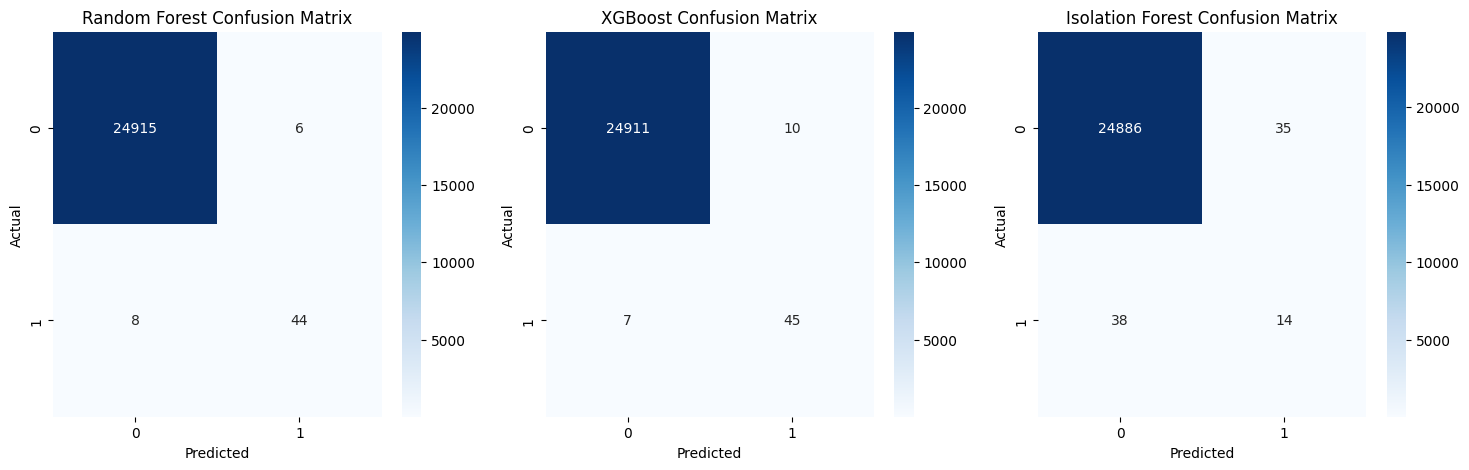

In [13]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = ['Random Forest', 'XGBoost', 'Isolation Forest']
predictions = [rf_preds, xgb_preds, isolation_preds]
for i, (model, preds) in enumerate(zip(models, predictions)):
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{model} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')


In [14]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

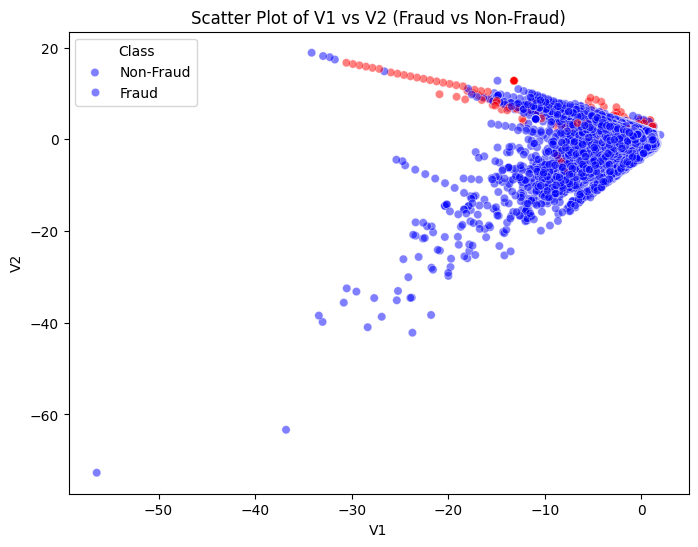

In [15]:
# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['V1'], y=X['V2'], hue=y, palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.title("Scatter Plot of V1 vs V2 (Fraud vs Non-Fraud)")
plt.xlabel("V1")
plt.ylabel("V2")
plt.legend(title="Class", labels=["Non-Fraud", "Fraud"])
plt.show()

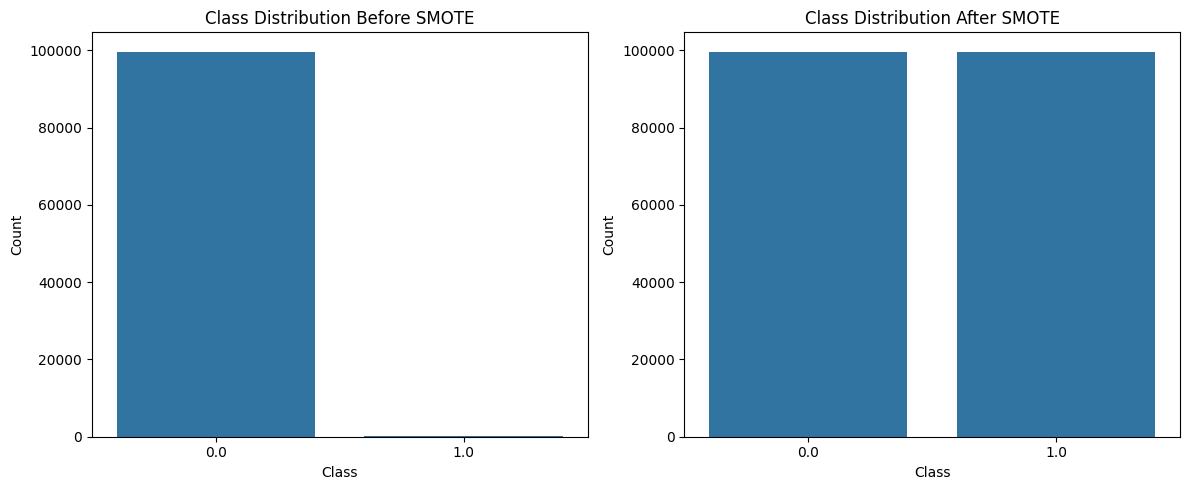

In [16]:
# Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values, ax=axes[0])
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

sns.barplot(x=pd.Series(y_train_resampled).value_counts().index,
            y=pd.Series(y_train_resampled).value_counts().values, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

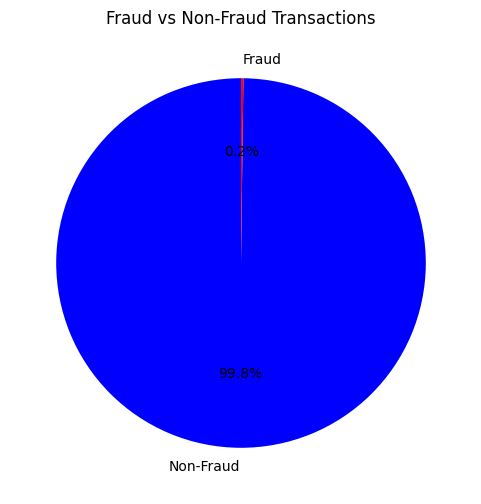

In [18]:
# Pie Chart
fraud_counts = df['Class'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(fraud_counts, labels=["Non-Fraud", "Fraud"], autopct="%1.1f%%", colors=['blue', 'red'], startangle=90)
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

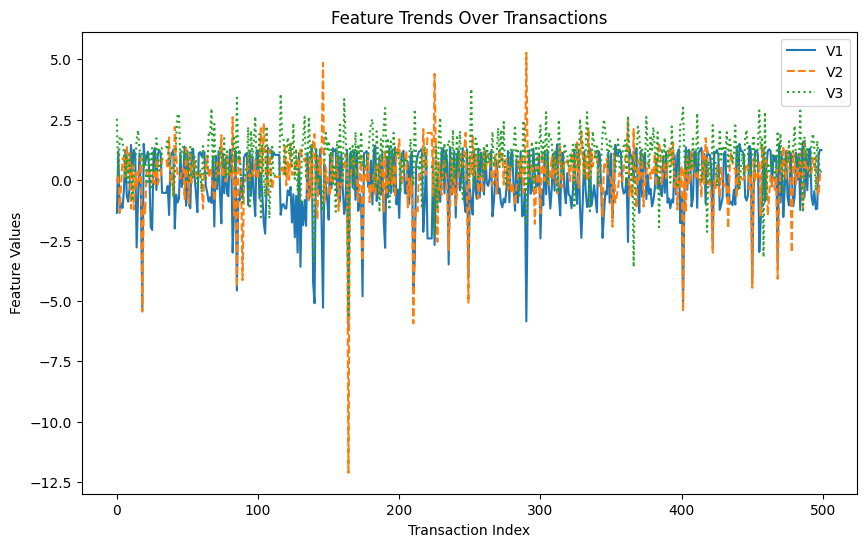

In [19]:
# Line Plot
plt.figure(figsize=(10, 6))
plt.plot(df.index[:500], df['V1'][:500], label="V1", linestyle="-")
plt.plot(df.index[:500], df['V2'][:500], label="V2", linestyle="--")
plt.plot(df.index[:500], df['V3'][:500], label="V3", linestyle=":")
plt.title("Feature Trends Over Transactions")
plt.xlabel("Transaction Index")
plt.ylabel("Feature Values")
plt.legend()
plt.show()